In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, roc_curve
from sklearn.linear_model import LogisticRegression as LR
from sklearn import metrics 
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import LeaveOneOut

In [2]:
data = pd.read_csv("../Data/10-14_features_filenames.csv")
data = data.dropna()

In [66]:
data.to_csv("output.csv")

In [4]:
data["class"].value_counts()

no_dust    1149
dust        396
Name: class, dtype: int64

In [5]:
# Use a simple regex to get unique HiRise ID location ID numbers.
# So that we can group images of the same region together.

# Separate out the digits which identify the photographed region:
# oooooo_tttt, i.e.
# <orbit_number>_<target_code>
from sklearn.model_selection import GroupKFold
import re
def target_regex(filename):
    region_string = re.search("[0-9]{6}_[0-9]{4}", filename)
    return int(region_string.group())

data["target_location"] = data["file_name"].apply(target_regex)

In [9]:
# Define image groups, input variables, output variables
groups = np.array(data["target_location"])
x = np.array(data.iloc[:,0:6])
y = np.array(data["class"])
y = [1 if name == "dust" else 0 for name in y]
print("Number of images: " + str(len(np.unique(groups))))
print("Unique image groups: " + str(len(np.unique(groups))))

Number of images: 402
Unique image groups: 402


In [10]:
# Show the 34% class imbalance
np.sum(data["class"] == "dust") / np.sum(data["class"] == "no_dust")

0.34464751958224543

In [12]:
# Use 10 folds,
# splitting the dataset into  CV sections
# with roughly 10 samples.
# Get accuracy, recall, precision.
# Sometimes no positive predictions are made,
# resulting in undefined precision, recall, and auc
def cv_scores(model, x, y, label, cv, groups=None):
    model_cv_results = cross_validate(model, x, y, cv=cv, groups=groups, scoring=["accuracy", "precision", "recall", "roc_auc"])
    model_cv_acc_mean = np.mean(model_cv_results["test_accuracy"])
    model_cv_precision_mean = np.mean(model_cv_results["test_precision"])
    model_cv_recall_mean = np.mean(model_cv_results["test_recall"])
    model_cv_auc_mean = np.mean(model_cv_results["test_roc_auc"])
    print(label)
    print("Accuracy: " + str(model_cv_acc_mean))
    print("Precision: " + str(model_cv_precision_mean))
    print("Recall: " + str(model_cv_recall_mean))
    print("AUC: " + str(model_cv_auc_mean))
    

In [13]:
# Define cv splitting objects for use in cv_scores function
group_kfold = GroupKFold(n_splits=10)
sfold = StratifiedKFold(10, shuffle=True)

In [16]:
# Logistic Regression - Without GroupKFold
lr_model = LR()
cv_scores(lr_model, x, y, "Logistic Regression With No Groups", sfold)

Logistic Regression With No Groups
Accuracy: 0.882865521575199
Precision: 0.816960509778846
Recall: 0.7047435897435899
AUC: 0.9337294783782198


In [69]:
# Logistic Regression - With GroupKFold
cv_scores(lr_model, x, y, "Logistic Regression With Groups", group_kfold, groups=groups)

Logistic Regression With Groups
Accuracy: 0.8769962295768747
Precision: 0.7796225434618291
Recall: 0.6876539130643103
AUC: 0.9372888085968419


In [60]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 500)
cv_scores(rf, x, y, "Random Forest With No Groups", sfold)

Random Forest With No Groups
Accuracy: 0.9204063678257226
Precision: 0.8661539379960432
Recall: 0.8182692307692306
AUC: 0.9689073593264098


In [61]:
cv_scores(rf, x, y, "Random Forest With Groups", group_kfold, groups)

Random Forest With Groups
Accuracy: 0.910603267700042
Precision: 0.8481705410160059
Recall: 0.7890957657353697
AUC: 0.9569351059925687


In [62]:
#Support Vector Classifier
from sklearn.svm import SVC
svc = SVC(random_state = 45, probability = True)
cv_scores(svc, x, y, "Support Vector Classifier With No Groups", sfold)

Support Vector Classifier With No Groups
Accuracy: 0.8524005027230833
Precision: 0.8292196812848986
Recall: 0.5322435897435899
AUC: 0.9383764742122868


In [63]:
cv_scores(svc, x, y, "Support Vector Classifier With Groups", group_kfold, groups)

Support Vector Classifier With Groups
Accuracy: 0.8517343946376205
Precision: 0.8006714698206453
Recall: 0.5334935572687663
AUC: 0.9399309304991504


In [64]:
group_kfold.split(x, y, groups)

<generator object _BaseKFold.split at 0x00000158B4946848>

In [ ]:
def group_kfolds_predict(model, x, y):
    group_kfold = GroupKFold(n_splits=10)
    for train_index, test_index in group_kfold.split(x, y, groups):
        x = np.array(x)
        y = np.array(y)
        x_train = x[train_index]
        x_test = x[test_index]
        y_train = y[train_index]
        y_test = y[test_index]
        model.fit(x_train, y_train)
        y_prob = model.predict_proba(x_test)[:,1]
        y_predict = model.predict(x_test)
        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_prob)
        plt.plot(fpr, tpr)

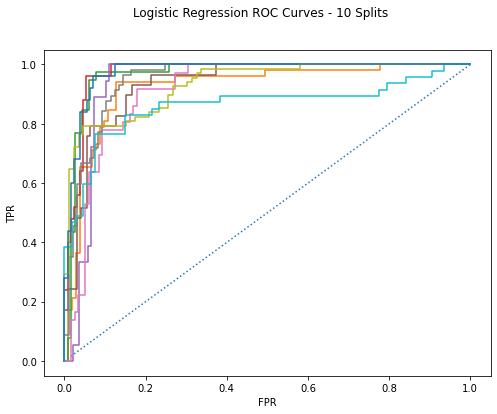

In [58]:
from sklearn.metrics import plot_roc_curve
fig = plt.gcf()
fig.set_size_inches(8,6)
fig.suptitle("Logistic Regression ROC Curves - 10 Splits")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.plot([0, 1], [0, 1], linestyle="dotted")
group_kfolds_predict(lr_model, x, y)


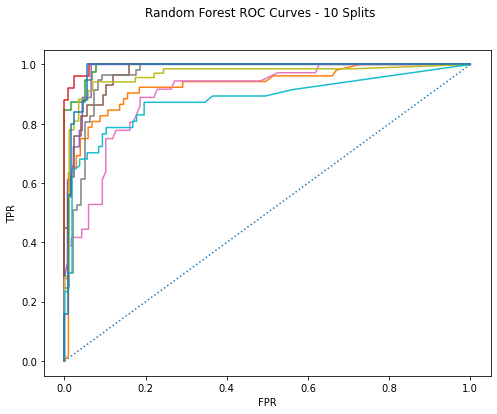

In [67]:
fig = plt.gcf()
fig.set_size_inches(8,6)
fig.suptitle("Random Forest ROC Curves - 10 Splits")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.plot([0, 1], [0, 1], linestyle="dotted")
group_kfolds_predict(rf, x, y)


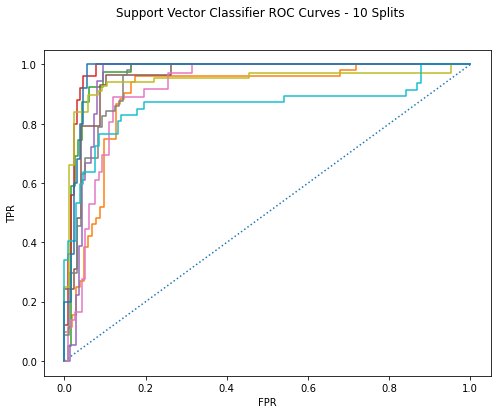

In [68]:
fig = plt.gcf()
fig.set_size_inches(8,6)
fig.suptitle("Support Vector Classifier ROC Curves - 10 Splits")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.plot([0, 1], [0, 1], linestyle="dotted")
group_kfolds_predict(svc, x, y)